In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

%cd /home/user_3/medistream-recsys/Script
from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

/home/user_3/medistream-recsys/Script


# Dataload

In [4]:
# products name 확인 용
products_df = pd.read_json("/fastcampus-data/products/products.json")
products_df = key_to_element(['_id'],products_df)

df = pd.read_json('/fastcampus-data/select_column_version_4.json')

## 전체 기간

In [6]:
df['date_paid'] = pd.to_datetime(df['date_paid'])
df['date_paid'].min(), df['date_paid'].max()

(Timestamp('2019-08-26 02:41:49.950000+0000', tz='UTC'),
 Timestamp('2022-09-13 08:59:21.151000+0000', tz='UTC'))

In [7]:
df['date_paid'].max() - df['date_paid'].min()

Timedelta('1114 days 06:17:31.201000')

# 전체 카테고리 판매율

In [115]:
df['name'].value_counts().head(10)

온라인 강의    73262
도서        54422
소모품       34400
한약재       22944
의료기기      12784
의약품       10071
식품         8374
의류/잡화      5331
치료실 물품     3979
가전/가구      3962
Name: name, dtype: int64

In [150]:
import matplotlib.font_manager as fm
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]
plt.rcParams["font.family"] = 'NanumGothic'

In [154]:
print ('버전: ', matplotlib.__version__)
print ('설치 위치: ', matplotlib.__file__)
print ('설정 위치: ', matplotlib.get_configdir())
print ('캐시 위치: ', matplotlib.get_cachedir())
print ('설정파일 위치: ', matplotlib.matplotlib_fname())
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

f = [f.name for f in fm.fontManager.ttflist]
print(len(font_list))
# 10개의 폰트명 만 출력
f[:10]

[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

버전:  3.5.0
설치 위치:  /home/user_4/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py
설정 위치:  /home/user_4/.config/matplotlib
캐시 위치:  /home/user_4/.cache/matplotlib
설정파일 위치:  /home/user_4/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc
62
62


[]

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/home/user_4/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_4/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_4/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_4/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_4/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 51032 (\N{

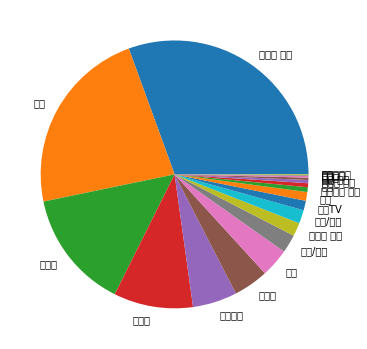

In [144]:
sum_ = df['name'].value_counts().head(10).sum()
data = round(df['name'].value_counts() / sum_, 3)
labels = ['온라인 강의', '도서', '소모품', '한약재', '의료기기', '의약품', '식품', '의류/잡화', '치료실 물품',
       '가전/가구', '메디TV', '생활', '오프라인 강의', '구독', '해부학 모형', '재활 용품', '디자인', '기타',
       '약속처방', '기획서비스', '주류']

plt.figure(figsize=(6,8))
plt.pie(data, labels = labels)
plt.show()

In [139]:
df['name'].value_counts().keys()

Index(['온라인 강의', '도서', '소모품', '한약재', '의료기기', '의약품', '식품', '의류/잡화', '치료실 물품',
       '가전/가구', '메디TV', '생활', '오프라인 강의', '구독', '해부학 모형', '재활 용품', '디자인', '기타',
       '약속처방', '기획서비스', '주류'],
      dtype='object')

In [121]:
df['name'].unique()

array([None, '의약품', '도서', '온라인 강의', '의료기기', '소모품', '가전/가구', '재활 용품', '식품',
       '구독', '의류/잡화', '오프라인 강의', '한약재', '디자인', '해부학 모형', '생활', '치료실 물품',
       '기타', '약속처방', '메디TV', '주류', '기획서비스'], dtype=object)

## filtering

In [8]:
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]

# 취소 안된 것만 가져오기
complete_df = df_only_paid[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]

# 도서 카테고리만 가져오기
only_book = complete_df[complete_df['name'] == '도서']

# 유저가 중복으로 아이템 구매 삭제
df_duplicated_book = only_book.drop_duplicates(subset=['customer_id','product_ids'])
df_book = df_duplicated_book.sort_values(by='date_paid').reset_index(drop=True)

In [9]:
# none 값 확인
df_book.isna().sum()

_id                 0
date_created        0
regular_price       0
sale_price          0
three_months        0
date_paid           0
customer_id         0
paid                0
name_x              0
category_id_y       0
product_ids         0
quantity            0
price               0
price_total         0
age_group        3007
한의사 여부             79
사업자 여부             79
cancelled           0
name                0
slug                0
dtype: int64

# 전체 데이터 EDA

### 데이터 중복 확인

In [10]:
# product_ids, name_x 일치하지 않음, 전처리 필요
len(df_book.product_ids.unique()), len(df_book.name_x.unique())

(342, 370)

In [11]:
# 중복 제거 후 수 비교 확인
len(df_book.drop_duplicates(subset=['product_ids','name_x']).name_x.unique())

370

product_id보다 name이 더 많다. 즉, 동일한 id의 가진 제품의 이름이 다른 경우가 있다는 의미이다. 

같은 id를 가진 제품은 모두 동일한 이름을 갖도록 전처리한다.

In [13]:
product_name_preprocess_df = df_book.copy()

In [14]:
# 각 마지막 product_ids, name으로 채우기
product_ids_to_name = {}
for idx, row in product_name_preprocess_df.iterrows():
    product_ids_to_name[row.product_ids] = row.name_x
product_name_preprocess_df['name_x'] = product_name_preprocess_df['product_ids'].apply(lambda x: product_ids_to_name[x])

name_to_product_ids = {}
for idx, row in product_name_preprocess_df.iterrows():
    name_to_product_ids[row.name_x] = row.product_ids
product_name_preprocess_df['product_ids'] = product_name_preprocess_df['name_x'].apply(lambda x: name_to_product_ids[x])

In [15]:
# product_ids, name_x 일치 확인
len(product_name_preprocess_df.product_ids.unique()), len(product_name_preprocess_df.name_x.unique())

(340, 340)

In [17]:
# name, product 전처리에 따라서 다시 중복 제거
df_reduplicated_book = product_name_preprocess_df.drop_duplicates(subset=['customer_id','product_ids'])
preprocessed_book_df = df_reduplicated_book.sort_values(by='date_paid').reset_index(drop=True)

### 데이터 수 확인

In [19]:
print('전체 유저 수:',len(set(preprocessed_book_df.customer_id)))
print('전체 아이템 수:', len(set(preprocessed_book_df.product_ids)))

전체 유저 수: 7410
전체 아이템 수: 340


전체 유저 수 대비 책을 구매한 유저의 비율이다.  
약 1.5%로 매우 낮은 편에 속한다.

In [24]:
# 전체 구매 백분율
print('전체 구매율: ', len(preprocessed_book_df)/(len(set(preprocessed_book_df.customer_id))*len(set(preprocessed_book_df.product_ids))))

전체 구매율:  0.015028578232912598


In [25]:
print('유저 최대 구매 횟수:',preprocessed_book_df.customer_id.value_counts().max())
print('유저 중간 구매 횟수:',preprocessed_book_df.customer_id.value_counts().median())
print('유저 최소 구매 횟수:',preprocessed_book_df.customer_id.value_counts().min())

유저 최대 구매 횟수: 130
유저 중간 구매 횟수: 3.0
유저 최소 구매 횟수: 1


# 날짜별 구매량 시각화

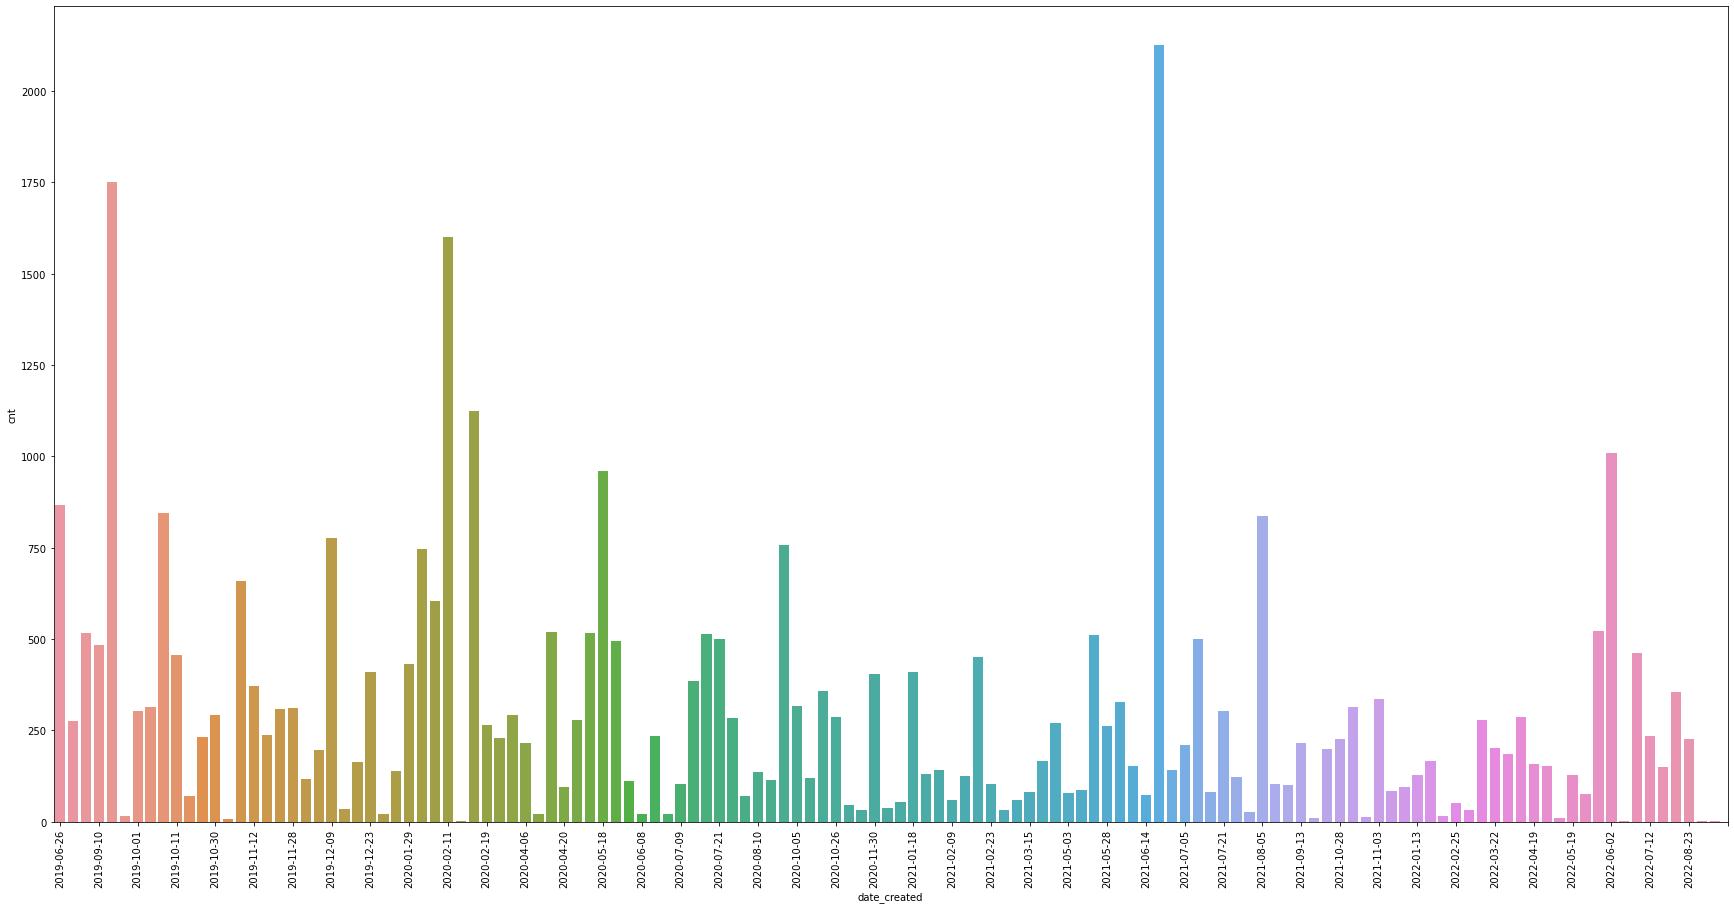

In [26]:
from datetime import datetime,date
preprocessed_book_df['date_created'] = pd.to_datetime(preprocessed_book_df['date_created']).dt.date

dat_groupby = preprocessed_book_df.groupby(['date_created'])[['product_ids']].count().reset_index().rename(columns={'product_ids':'cnt'})
dat_sort = dat_groupby.sort_values(by='date_created')

x = dat_sort['date_created']
y = dat_sort['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 3))
plt.xticks(rotation=90)
plt.show()

* 특정 일자에 갑자기 구매량이 급격히 증가하는 현상을 보임
* 주마다 도서에 대한 프로모션을 진행하는 것을 확인

    -> 프로모션에 의한 구매는 제거하는 것 고려

In [35]:
dat_sort.describe()

,cnt
count,129.000000
mean,293.511628
std,334.229527
min,1.000000
25%,85.000000
50%,210.000000
75%,371.000000
max,2126.000000


In [34]:
dat_sort.sort_values(['cnt'], ascending = False).head(10)

,date_created,cnt
85,2021-06-21,2126
4,2019-09-11,1750
30,2020-02-11,1600
32,2020-02-18,1125
120,2022-06-02,1008
42,2020-05-18,961
0,2019-06-26,868
8,2019-10-10,844
93,2021-08-05,838
21,2019-12-09,776


###**구매량이 많은 날짜에 구매된 책들이 무엇인지 알아보기. 그래야 프로모션이 영향이 있었는지 판단가능**

### Most Popular(프로모션 구매 포함)

In [85]:
most_popular_list = preprocessed_book_df.groupby(['name_x','product_ids']).count()['customer_id'].reset_index().rename(columns={'customer_id':'cnt'})

In [86]:
dt_sort_cnt = preprocessed_book_df.copy()
dt_sort_cnt_add = pd.merge(dt_sort_cnt, most_popular_list[['product_ids','cnt']], how='left', on='product_ids')

In [87]:
top20_product_ids = most_popular_list.sort_values(by='cnt',ascending=False).head(20).product_ids.values

In [90]:
top20_df = dt_sort_cnt_add[dt_sort_cnt_add['product_ids'].isin(top20_product_ids)].drop_duplicates(subset=['name_x','product_ids'], ignore_index=True)
top20_df.sort_values(by=['date_created','cnt'], ascending=False)[['date_created','sale_price','three_months','name_x','product_ids','cnt']]

,date_created,sale_price,three_months,name_x,product_ids,cnt
19,2022-06-29,57000.0,463.0,플로차트 정형외과 진단,62bbee3a08e04900234e36c8,461
18,2022-06-02,42750.0,596.0,비만문답,629860599d93880024071acc,592
17,2021-08-05,76500.0,109.0,임상 한의사를 위한 기본 한약처방 강의 2판,610b6f9ad26af90681b1e699,838
16,2021-07-09,36100.0,35.0,침의 과학적 접근의 이해,60e7e0b0d26af90681b1b61c,499
15,2021-06-21,18000.0,219.0,윤상훈·권병조의 알짜 근육학,60d018b7d26af90681b18980,2126
14,2021-05-17,18000.0,0.0,통장잔고 2배 늘려주는 병의원 절세비법,60a22e62c1908b001a6466e1,512
13,2021-01-18,64800.0,28.0,근골격계 약침의학,6005151da6432d001a69b21b,409
12,2020-09-21,45000.0,46.0,사상방 사용설명서,5f6860f348060c52caf14690,757
11,2020-04-27,45000.0,4.0,사진으로 공부하는 이비인후과학,5ea643ec1a3ca36b96784a07,516
10,2020-04-13,47700.0,6.0,한방처방정석,5e93e5d6bfe426094478533e,520


# product_id별 누적 판매량

In [92]:
before_product_df = preprocessed_book_df.groupby('product_ids')[['product_ids']].count().rename(columns={'product_ids':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)

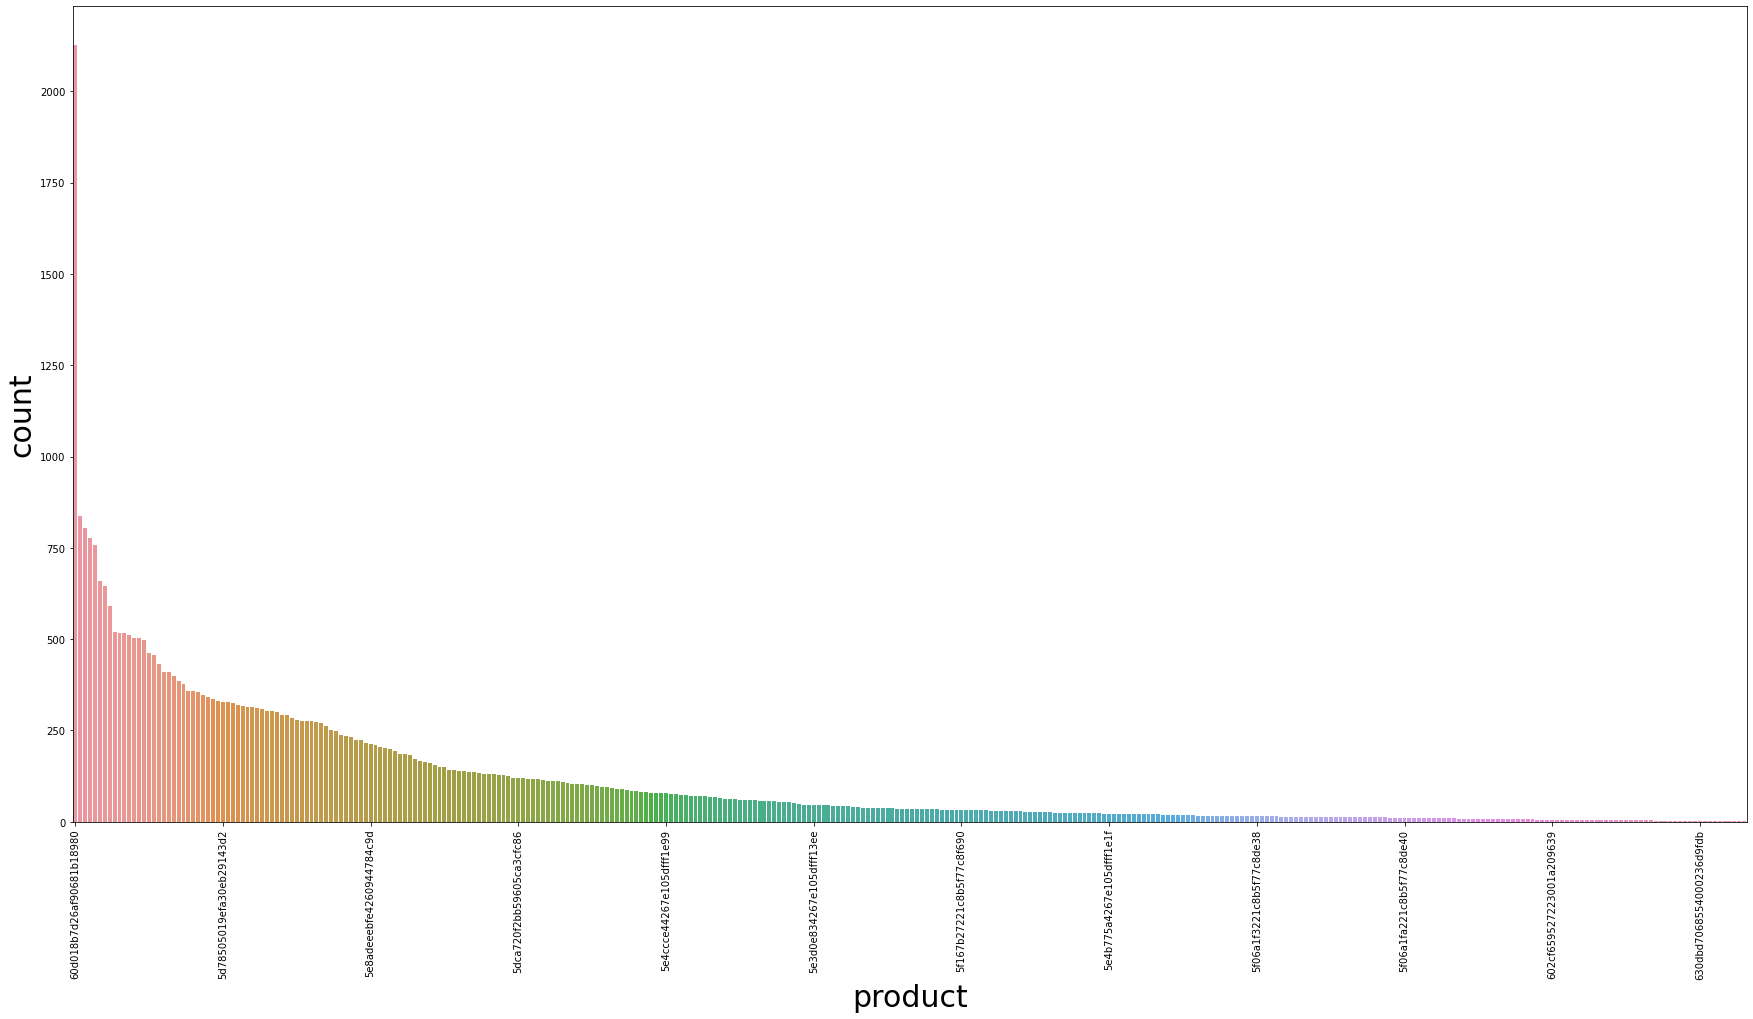

In [93]:
x = before_product_df['product_ids']
y = before_product_df['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
ax.set_xlabel('product',fontsize=30)
ax.set_ylabel('count',fontsize=30)
plt.xticks(rotation=90)
plt.show()

In [94]:
print('제품 누적 판매 횟수:', before_product_df.max())
print('제품 medina 판매 횟수:', before_product_df.median())

제품 누적 판매 횟수: product_ids    63182f4d6c2e37002369d6bc
cnt                                2126
dtype: object
제품 medina 판매 횟수: cnt    35.0
dtype: float64


# 고객 segment별 나이 비율

In [108]:
# 원장님
ceo_doctor = df[(df['한의사 여부'] == 1.0) & (df['사업자 여부'] == 1.0)]

# 페이 닥터
pay_doctor = df[(df['한의사 여부'] == 1.0) & (df['사업자 여부'] == 0.0)]

# 한의대생
student = df[(df['한의사 여부'] == 0.0) & (df['사업자 여부'] == 0.0)]

# 창업가?
ceo = df[(df['한의사 여부'] == 0.0) & (df['사업자 여부'] == 1.0)]

all = [ceo, ceo_doctor, student, pay_doctor]


print('고객 segment별 나이 비율: ')
print()
all = [ceo_doctor, pay_doctor, ceo, student]
all2 = ['ceo_doctor', 'pay_doctor', 'ceo', 'student']

for i in range(len(all)):
    print(f'[{all2[i]}]')
    a = all[i].age_group.value_counts().sum()
    print(round(all[i].age_group.value_counts() / a, 2))
    print()

고객 segment별 나이 비율: 

[ceo_doctor]
30-39    0.55
40-49    0.25
20-29    0.11
50-59    0.08
60-      0.01
Name: age_group, dtype: float64

[pay_doctor]
20-29    0.62
30-39    0.31
40-49    0.06
50-59    0.02
60-      0.00
0-9      0.00
Name: age_group, dtype: float64

[ceo]
30-39    0.65
20-29    0.17
40-49    0.17
50-59    0.01
Name: age_group, dtype: float64

[student]
20-29    0.84
30-39    0.13
40-49    0.02
50-59    0.01
60-      0.00
10-19    0.00
0-9      0.00
Name: age_group, dtype: float64



**병원장(ceo_doctor)을 제외한 모든 segment에서 2030의 비율이 제일 높다.**

# 고객별 누적 판매횟수

In [98]:
before_user_group_df = all_promotion_df.groupby('customer_id')[['customer_id']].count().rename(columns={'customer_id':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)
x = before_user_group_df['customer_id']
y = before_user_group_df['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
ax.set_xlabel('customer',fontsize=30)
ax.set_ylabel('count',fontsize=30)
plt.xticks(rotation=90)
plt.show()

NameError: name 'all_promotion_df' is not defined

In [99]:
print('유저 최대 누적 구매 횟수:',before_user_group_df.max())
print('유저 median 누적 구매 횟수:',before_user_group_df.median())

NameError: name 'before_user_group_df' is not defined

In [100]:
df

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
0,5d60cebb4e77525ec5ca141c,NaT,NaN,NaN,NaN,NaT,5d60cea34e77525ec5ca1413,False,None,None,None,NaN,NaN,NaN,20-29,1.0,0.0,False,None,None
1,5d60daf14e77525ec5ca1497,2019-08-21 05:04:55.728000+00:00,66000.0,0.0,NaN,NaT,5d60ceba4e77525ec5ca1419,False,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,20-29,1.0,0.0,True,의약품,medicine
2,5d60d2d04e77525ec5ca145b,2019-08-21 05:04:55.728000+00:00,66000.0,0.0,NaN,2019-09-06 09:13:26.749000+00:00,5d60d0a94e77525ec5ca1446,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,30-39,0.0,1.0,False,의약품,medicine
3,5d60e27c4e77525ec5ca14b6,2019-10-16 04:03:00.777000+00:00,44800.0,37900.0,0.0,2019-10-21 02:18:23.528000+00:00,5d60e2694e77525ec5ca14b5,True,"한의원 원장님도 기획자가 돼야한다 생각한다면, 읽어야 하는 책",5cf8bbba0098b2225c5dfaa3,5da696740dabe405b156eb5c,1.0,37000.0,37000.0,20-29,0.0,0.0,False,도서,book
4,5d60f8764e77525ec5ca14e5,NaT,NaN,NaN,NaN,NaT,5d60f3a74e77525ec5ca14da,False,None,None,None,NaN,NaN,NaN,40-49,1.0,1.0,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266653,632044cb6c2e37002369f129,2022-02-16 04:01:35.033000+00:00,41500.0,35200.0,NaN,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 황기(편) (5묶음) 600g*5ea, 중국",5fb32f7a5120316334323fd8,620c771fd41623002392d61b,1.0,35200.0,35200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266654,632044cb6c2e37002369f129,2020-11-20 06:59:35.395000+00:00,4900.0,4200.0,NaN,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 어성초 600g, 중국",5fb32f7a5120316334323fd8,5fb769575120316334324a69,1.0,4200.0,4200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266655,632044cb6c2e37002369f129,2020-11-20 06:59:36.047000+00:00,3900.0,3300.0,NaN,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 여정실 600g, 중국",5fb32f7a5120316334323fd8,5fb769585120316334324a6a,1.0,3300.0,3300.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266656,632045696c2e37002369f136,2022-08-30 00:42:13.239000+00:00,330000.0,0.0,386.0,2022-09-13 08:59:21.151000+00:00,628ecb419d9388002406f007,True,맘 편하게 한약 처방하기,5ea40b671a3ca36b967849ad,630d5ce568554000236d9a5d,1.0,264000.0,264000.0,None,1.0,0.0,False,온라인 강의,lecture
